# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import statsmodels.api as sm
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, RandomizedSearchCV, GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load the data 

In [3]:
df = pd.read_csv('../data/Bengaluru_House_data_cleaned.csv')
df.head()

,area_type,availability,location,total_sqft,bath,balcony,rooms,price
0,Super built-up Area,0.0,1st Block Jayanagar,2850.0,4.0,1.0,4,428.0
1,Super built-up Area,0.0,1st Block Jayanagar,1630.0,3.0,2.0,3,194.0
2,Super built-up Area,1.0,1st Block Jayanagar,1875.0,2.0,3.0,3,235.0
3,Built-up Area,0.0,1st Block Jayanagar,1200.0,2.0,0.0,3,130.0
4,Super built-up Area,0.0,1st Block Jayanagar,1235.0,2.0,2.0,2,148.0


# Checking correlation of features

In [4]:
df_test = df.drop(columns=['area_type','location'])
corr = df_test.corr()
corr

,availability,total_sqft,bath,balcony,rooms,price
availability,1.000000,0.008885,0.047489,0.119712,0.072025,0.040563
total_sqft,0.008885,1.000000,0.080495,0.013243,0.077208,0.105484
bath,0.047489,0.080495,1.000000,0.242708,0.893812,0.598543
balcony,0.119712,0.013243,0.242708,1.000000,0.228755,0.156884
rooms,0.072025,0.077208,0.893812,0.228755,1.000000,0.566317
price,0.040563,0.105484,0.598543,0.156884,0.566317,1.000000


<Axes: >

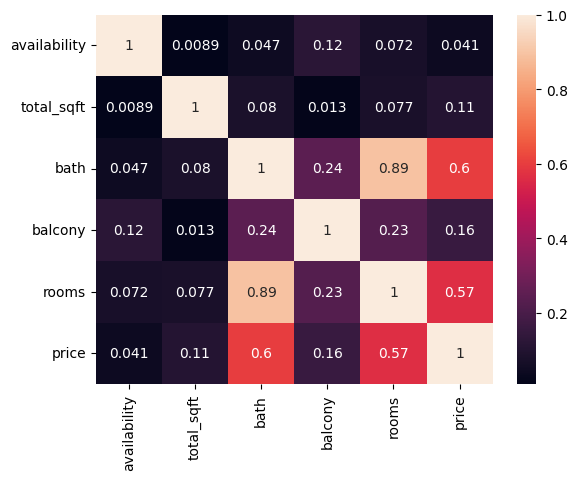

In [5]:
sns.heatmap(corr,annot=True)

Since bath and rooms have high correlation, we will choose rooms as the feature for training to
avoid multicollinearity. Feature we choose are as follows :-
- **availability**
- **total_sqft**
- **balcony**
- **rooms**

# Get dummy data


In [6]:
df = df.drop(columns=['area_type','bath'])

In [7]:
df_dum = pd.get_dummies(df['location'],drop_first=False)
df_dum.head()

,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,others
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
df = pd.concat( [df,df_dum.drop(columns=['others'])] , axis='columns')
df.head()

,availability,location,total_sqft,balcony,rooms,price,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,0.0,1st Block Jayanagar,2850.0,1.0,4,428.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.0,1st Block Jayanagar,1630.0,2.0,3,194.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,1st Block Jayanagar,1875.0,3.0,3,235.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,1st Block Jayanagar,1200.0,0.0,3,130.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,1st Block Jayanagar,1235.0,2.0,2,148.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
df.drop(columns='location',inplace=True)
df.head()

,availability,total_sqft,balcony,rooms,price,1st Block Jayanagar,1st Phase JP Nagar,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,0.0,2850.0,1.0,4,428.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.0,1630.0,2.0,3,194.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.0,1875.0,3.0,3,235.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.0,1200.0,0.0,3,130.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.0,1235.0,2.0,2,148.0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Train-test split 

In [10]:
# minmax = MinMaxScaler()

In [11]:
X = df.drop(['price'],axis=1)
Y = df.price

In [12]:
print(X.shape,Y.shape)

(6960, 237) (6960,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=30)

In [14]:
# X_train = minmax.fit_transform(X_train)

In [15]:
# X_test = minmax.transform(X_test)

In [16]:
# type(X_train)

In [17]:
# a = pd.DataFrame(X_train)
# a.head()

# OLS Regression

In [18]:
'''
X_sm = sm.add_constant(X)
model = sm.OLS(Y,X_sm)
model.fit().summary()
'''

'\nX_sm = sm.add_constant(X)\nmodel = sm.OLS(Y,X_sm)\nmodel.fit().summary()\n'

# Linear Regression 

In [19]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.44328155204230435

## Using kfold validation to measure the accuracy of linear regression model 

In [20]:
K = 10
cv = ShuffleSplit(n_splits=K, test_size=0.2, random_state=42)

print(f' cross validation score k={K} \n',cross_val_score(lr,X,Y,cv=cv))
print("------------------------")
print(' mean of cross validation score \n',np.mean(cross_val_score(lr,X,Y,cv=cv)))

 cross validation score k=10 
 [   0.52133928 -202.01921365    0.57120792    0.55894591    0.46587309
    0.64054929    0.56051595    0.6114142     0.53839033    0.48509814]
------------------------
 mean of cross validation score 
 -19.706587953747395


# Lasso 

In [21]:
ls = Lasso()
ls.fit(X_train,y_train)
np.mean(cross_val_score(ls, X_train, y_train, scoring = 'neg_mean_absolute_error', cv = cv))

-42.49093332683608

In [22]:
def find_best_model_using_grid_searchcv(X,y):
    
    """
    algos ={
        'model_name_1':{
            'model': model_method(),
            'param' : {
                'parameter_1' : [xxx, xxx]
            }
        },
        'model_name_2' :{
            'model' : model_method(),
            'param' : {
                'parameter_1' : [xxx,xxx],
                'parameter_2' : ['xxx','xxx']
            }
        }
    }
    
    """
    
    algos ={
        'linear_regression':{
            'model': LinearRegression(),
            'param' : {
                'fit_intercept' : [True, False]
            }
        },
        'lasso' :{
            'model' : Lasso(),
            'param' : {
                'alpha' : [1,2],
                'selection' : ['random','cyclic']
            }
        },
        'decision_tree':{
            'model' : DecisionTreeRegressor(),
            'param' : {
                'criterion' : ['mse','friedman_mse'],
                'splitter' : ['best','random']
            }
        },
        'xg_boost':{
            'model' : xgb.XGBRegressor(),
            'param' : {
                'max_depth' : [3,5,10,15],
                'n_estimators' : [20,50,100,150]
            }
        }
    }
    
    scores= []
    CV = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'],config['param'],cv=CV, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model' : algo_name,
            'best_score' : gs.best_score_,
            'best_param' : gs.best_params_
        })
    
    print (gs.best_estimator_)
    return pd.DataFrame(scores,columns=['model','best_score','best_param'])

best_model = find_best_model_using_grid_searchcv(X,Y)
best_model = best_model.sort_values(by=['best_score'],ascending=False)
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


,model,best_score,best_param
3,xg_boost,0.771624,"{'max_depth': 3, 'n_estimators': 150}"
2,decision_tree,0.697337,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
0,linear_regression,-19.706588,{'fit_intercept': True}
1,lasso,-24.436473,"{'alpha': 1, 'selection': 'random'}"


In [23]:
np.where(X.columns=='1st Block Jayanagar')[0][0]

4

In [24]:
X.columns

Index(['availability', 'total_sqft', 'balcony', 'rooms', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Stage Nagarbhavi', '5th Block Hbr Layout',
       '5th Phase JP Nagar', '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=237)

In [25]:
len(X.columns)

237

In [26]:
np.zeros(238)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
xgbr = xgb.XGBRegressor(max_depth=3,n_estimators=150)
xgbr.fit(X_train,y_train)

def predict_price(location,availability,total_sqft,balcony,rooms):
    loc_index = np.where(X.columns == location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = availability
    x[1] = total_sqft
    x[2] = balcony
    x[3] = rooms
    if loc_index >= 0:
        x[loc_index] = 1
        
    return xgbr.predict([x])[0]

In [28]:
predict_price('1st Block Jayanagar',0,1235,2,4)

159.6309

In [29]:
import pickle

with open('banglore_house_price_model.pickle','wb') as f:
    pickle.dump(xgbr,f)

In [30]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))